# How to build an CV Training Pipeline using SageMaker Pipeline

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Dataset](#Dataset)
5. [Build SageMaker Pipeline](#Build-SageMaker-Pipeline)
    1. [Bring Your Own Container (BYOC)](#Bring-Your-Own-Container-(BYOC))
    2. [Set Pipeline input parameters](#Set-Pipeline-input-parameters)
    3. [Define Cache Configuration](#Define-Cache-Configuration)
    4. [Preprocess data step](#Preprocess-data-step)
    5. [Training step](#Training-step)
    6. [Model evaluation step](#Model-evaluation-step)
    7. [Register model step](#Register-model-step)
    8. [Accuracy condition step](#Accuracy-condition-step)
    9. [Pipeline Creation](#Pipeline-Creation)
    10. [Submit and trig pipeline](#Submit-and-trig-pipeline)
    11. [Analyzing Results](#Analyzing-Results)
6. [Execute same pipeline in one continuous script](#Execute-same-pipeline-in-one-continuous-script)
7. [Build Custom Project Templates (Optional)](#Build-Custom-Project-Templates-(Optional))
    1. [Setup Service Catalog Portfolio](#Setup-Service-Catalog-Portfolio)
7. [Clean Up](#Clean-up)

# Introduction

This notebook demonstrate how to build a reusable computer vision (CV) pattern using **SageMaker Pipeline**. This particular pattern goes through preprocessing, training, and evaluating steps for 2 different training jobs:1) Spot training and 2) On Demand training.  If the accuracy meets certain requirements, the models are then registered with SageMaker Model Registry.

We have also tagged the training workloads: `TrainingType: Spot or OnDemand`.  If you are interested and have permission to access billing of your AWS account, you the cost savings from spot training from the side-by-side comparison. To enable custom cost allocation tags, please follow this [AWS documentation](https://docs.aws.amazon.com/awsaccountbilling/latest/aboutv2/activating-tags.html).  It takes 12-48 hrs for the new tag to show in your cost explore.

![Spot Training](statics/cost-explore.png)

SageMaker pipelines works on the concept of steps. The order steps are executed in is inferred from the dependencies each step have. If a step has a dependency on the output from a previous step, it's not executed until after that step has completed successfully. This also allows SageMaker to create a **Direct Acyclic Graph, DAG,** that can be visuallized in Amazon SageMaker Studio (see diagram above). The DAG can be used to track pipeline executions, inputs/outputs and metrics, giving user the full lineage of the model creation.

![Training Pipeline](statics/cv-training-pipeline.png)

** Note: This Notebook was tested on Data Science Kernel in SageMaker Studio**

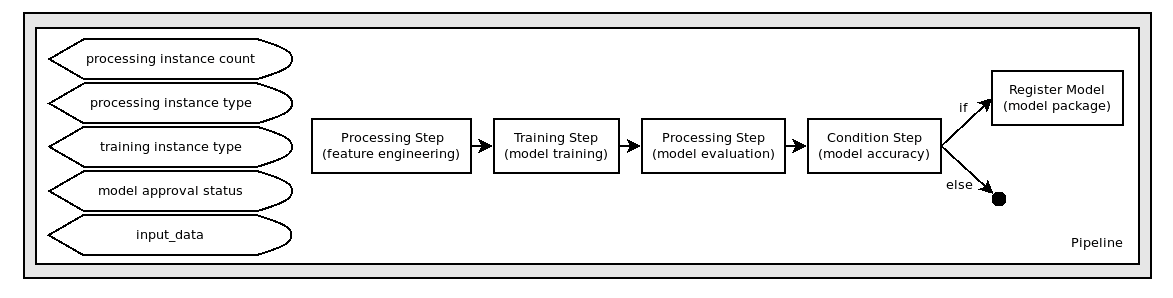

## Setup

Here we define the sagemaker session, default bucket, job prefixes, pipeline and model group names

We are using some of the newly released SageMaker Pipeline features.  Please make sure you ugrade your sageMaker version by running the cell below.

In [2]:
!pip install -U sagemaker --quiet # Ensure latest version of SageMaker is installed

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.16 requires botocore==1.29.16, but you have botocore 1.29.25 which is incompatible.
aiobotocore 1.2.2 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.29.25 which is incompatible.


In [24]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

default_bucket = sagemaker_session.default_bucket() # or use your own custom bucket name
base_job_prefix = "cv-week4" # or define your own prefix

model_package_group_name = f"{base_job_prefix}-model-group"  # Model name in model registry
pipeline_name = f"{base_job_prefix}-pipeline"  # SageMaker Pipeline name
print(model_package_group_name)

cv-week4-model-group


## Dataset
The dataset we are using is from [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found here). Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels. Bounding boxes are provided, as are annotations of bird parts. A recommended train/test split is given, but image size data is not.

![Bird Dataset](statics/birds.png)

Run the cell below to download the full dataset or download manually [here](https://course.fast.ai/datasets). Note that the file size is around 1.2 GB, and can take a while to download. If you plan to complete the entire workshop, please keep the file to avoid re-download and re-process the data.

In [38]:
%%time
!wget 'https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz'
!tar xopf CUB_200_2011.tgz
!rm CUB_200_2011.tgz

--2022-12-08 11:42:57--  https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.206, 52.216.109.101, 52.217.17.70, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  47.8MB/s    in 26s     

2022-12-08 11:43:25 (43.0 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]

CPU times: user 4.53 s, sys: 1.26 s, total: 5.79 s
Wall time: 4min 46s


In [39]:
%%time
# upload data to s3
s3_raw_data = f's3://{default_bucket}/{base_job_prefix}/full/data'
!aws s3 cp --recursive ./CUB_200_2011 $s3_raw_data --quiet

CPU times: user 1.45 s, sys: 358 ms, total: 1.81 s
Wall time: 1min 39s


In [ ]:
%%time
# remove data to save disc space
!rm -rf ./CUB_200_2011
!rm -f attributes.txt

## Build SageMaker Pipeline

### Set Pipeline input parameters
Define Pipeline parameters that you can use to parametrize the pipeline. Parameters enable custom pipeline executions and schedules without having to modify the Pipeline definition.

The supported parameter types include:

* ParameterString - represents a str Python type
* ParameterInteger - represents an int Python type
* ParameterFloat - represents a float Python type

These parameters support providing a default value, which can be overridden on pipeline execution. The default value specified should be an instance of the type of the parameter.

![Parameter Input](statics/parameters-input.png)

In [26]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

# Parameters for pipeline execution
processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount", default_value=1
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"  # ModelApprovalStatus can be set to a default of "Approved" if you don't want manual approval.
)

input_data = ParameterString(
    name="InputDataUrl",
    default_value=s3_raw_data
)

input_annotation = ParameterString(
    name="AnnotationFileName",
    default_value="classes.txt"
)

# This is a large dataset, we are only going to train a subset of the classes
class_selection = ParameterString(
    name="ClassSelection",
    default_value="13, 17, 35, 36, 47, 68, 73, 87" #If use the mini dataset, please make sure to use the class index with the available list
)

processing_instance_type = "ml.m5.4xlarge"
training_instance_count = 2
training_instance_count_spot = 1
training_instance_type = "ml.c5.9xlarge"
training_instance_type_spot = "ml.c5.4xlarge"

### Define Cache Configuration
When step cache is defined, before SageMaker Pipelines executes a step, it attempts to find a previous execution of a step that was called with the same arguments.

Pipelines doesn't check whether the data or code that the arguments point to has changed. If a previous execution is found, Pipelines will propagates the values from the cache hit during execution, rather than recomputing the step.

Step caching is available for the following step types:

* Training
* Tuning
* Processing
* Transform

In [27]:
from sagemaker.workflow.steps import CacheConfig

## By enabling cache, if you run this pipeline again, without changing the input 
## parameters it will skip the training part and reuse the previous trained model
cache_config = CacheConfig(enable_caching=True, expire_after="30d")

### Preprocess data step
We are taking the original code in Jupyter notebook and containerized script to run in a preprocessing job.

This script first down sample the dataset base on the ClassSelection parameter argument, then uses the manifest file (classes.txt) and split the data into train, validate, and test and store the data and manifest files to s3 bucket.

We are going to use **SKLearnProcessor** to process the data. for more detail on different type of processing jobs, please refer to the amazon documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html)

1. build the preprocess python script (define s3 input and output)
2. build the custom container
3. Run sagemaker processing job

In [28]:
from sagemaker.workflow.steps import ProcessingStep

from sagemaker.sklearn.processing import SKLearnProcessor

from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
)
import uuid

# SKlearnProcessor for preprocessing

sklearn_processor = SKLearnProcessor(base_job_name = f"{base_job_prefix}-preprocess",  # choose any name
                                    framework_version='0.20.0',
                                    role=role,
                                    instance_type=processing_instance_type,
                                    instance_count=processing_instance_count)

output_s3_uri = f's3://{default_bucket}/{base_job_prefix}/outputs/{uuid.uuid4()}'

step_process = ProcessingStep(
    name="BirdClassificationPreProcess",  # choose any name
    processor=sklearn_processor,
    code="preprocess.py",
    job_arguments=["--classes", class_selection,
                "--input-data", input_annotation],
    inputs=[ProcessingInput(source=input_data, 
            destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name='train_data', 
                         source="/opt/ml/processing/output/train", 
                         destination = output_s3_uri +'/train'),
        ProcessingOutput(output_name='val_data',
                         source="/opt/ml/processing/output/validation", 
                         destination = output_s3_uri +'/validation'),
        ProcessingOutput(output_name='test_data',
                         source="/opt/ml/processing/output/test", 
                         destination = output_s3_uri +'/test'),
        ProcessingOutput(output_name='manifest',
                         source="/opt/ml/processing/output/manifest", 
                         destination = output_s3_uri +'/manifest'),
    ],
    cache_config=cache_config
    )

### Training step
We are using SageMaker's TensorFlow container, the custom TensorFlow training code is provided via a Python script in a separate file that gets passed to SageMaker.

Our Pipeline experiments with 2 training jobs, Spot and On Demand, side-by-side.  Each workload is tagged using 'TrainingType'.  It you have the permission, you can enable the User defined tag in Cost Explore and compare the cost difference between spot and on demand training.  [Here](https://docs.aws.amazon.com/awsaccountbilling/latest/aboutv2/activating-tags.html) is how to enable user-defined tags.

In [29]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep
from sagemaker.tensorflow import TensorFlow

TF_FRAMEWORK_VERSION = '2.4.1'

hyperparameters = {'initial_epochs':     4,
                   'batch_size':         8,
                   'fine_tuning_epochs': 20, 
                   'dropout':            0.4,
                   'data_dir':           '/opt/ml/input/data'}

metric_definitions = [{'Name': 'loss',      'Regex': 'loss: ([0-9\\.]+)'},
                  {'Name': 'acc',       'Regex': 'accuracy: ([0-9\\.]+)'},
                  {'Name': 'val_loss',  'Regex': 'val_loss: ([0-9\\.]+)'},
                  {'Name': 'val_acc',   'Regex': 'val_accuracy: ([0-9\\.]+)'}]

if training_instance_count > 1:
    distribution = {'parameter_server': {'enabled': True}}
    DISTRIBUTION_MODE = 'ShardedByS3Key'
else:
    distribution = {'parameter_server': {'enabled': False}}
    DISTRIBUTION_MODE = 'FullyReplicated'
    
train_in = TrainingInput(s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri,
                         distribution=DISTRIBUTION_MODE)
test_in  = TrainingInput(s3_data=step_process.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri,
                         distribution=DISTRIBUTION_MODE)
val_in   = TrainingInput(s3_data=step_process.properties.ProcessingOutputConfig.Outputs["val_data"].S3Output.S3Uri,
                         distribution=DISTRIBUTION_MODE)

inputs = {'train':train_in, 'test': test_in, 'validation': val_in}

In [30]:
training_steps = dict()

training_estimators = dict()
# get out model artifacts location
models = dict()

training_options = ['Spot', 'OnDemand']

for t in training_options:
    tags = dict()
    tags['Key'] = 'TrainingType'
    tags['Value'] = t
        # Training step for generating model artifacts
    model_path = f"s3://{default_bucket}/{base_job_prefix}/output/models"
    checkpoint_s3_uri = f"s3://{default_bucket}/{base_job_prefix}/outputcheckpoints"
    
    if t.lower() == 'spot':
        estimator = TensorFlow(entry_point='train-mobilenet.py',
                               source_dir='code',
                               output_path=model_path,
                               instance_type=training_instance_type_spot,
                               instance_count=training_instance_count_spot,
                               distribution=distribution,
                               hyperparameters=hyperparameters,
                               metric_definitions=metric_definitions,
                               role=role,
                               use_spot_instances=True,
                               max_run=60*60*10,
                               max_wait=60*60*12, # Seconds to wait for spot instances to become available
                               checkpoint_s3_uri=checkpoint_s3_uri,
                               framework_version=TF_FRAMEWORK_VERSION, 
                               py_version='py37',
                               base_job_name=base_job_prefix,
                               script_mode=True,
                               tags=[tags])
    else:
        estimator = TensorFlow(entry_point='train-mobilenet.py',
                       source_dir='code',
                       output_path=model_path,
                       instance_type=training_instance_type,
                       instance_count=training_instance_count,
                       distribution=distribution,
                       hyperparameters=hyperparameters,
                       metric_definitions=metric_definitions,
                       role=role,
                       framework_version=TF_FRAMEWORK_VERSION, 
                       py_version='py37',
                       base_job_name=base_job_prefix,
                       script_mode=True,
                       tags=[tags])
        
    step_train = TrainingStep(
        name=f"BirdClassification{t}Train",
        estimator=estimator,
        inputs=inputs,
        cache_config=cache_config
    )
    
    training_steps[t] = step_train
    training_estimators[t] = estimator
    models[t] = step_train.properties.ModelArtifacts.S3ModelArtifacts

/opt/conda/lib/python3.7/site-packages/sagemaker/workflow/steps.py:445: UserWarning: Profiling is enabled on the provided estimator. The default profiler rule includes a timestamp which will change each time the pipeline is upserted, causing cache misses. If profiling is not needed, set disable_profiler to True on the estimator.
  warnings.warn(msg)


### Model evaluation step
We are going to use a ProcessingStep for our model evaluation, and we are going to use our own container from the earlier step.

Evaluation script does the following:
1. Loading the tf model 
2. Run prediction
3. Compare predicts vs actuals and generate the confussion matrix

when you register this model to the model registery, metrics generated from this step will be attached to the model version and can be visualized in SageMaker Studio like this:

![Confusion Matrix](statics/confussion_matrix.png)

Here are more details on the list of metric available for each type of ML problems: [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html)

In [31]:
# from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.pipeline_context import PipelineSession

from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
    FrameworkProcessor,
)

eval_steps = dict()
eval_reports = dict()

pipeline_session = PipelineSession()

for t in training_options:
    
    script_eval = FrameworkProcessor(
        estimator_cls=TensorFlow,
        framework_version=TF_FRAMEWORK_VERSION,
        base_job_name = f"{base_job_prefix}-evaluation",
        command=['python3'],
        py_version="py37",
        role=role,
        instance_count=processing_instance_count,
        instance_type=processing_instance_type,
        sagemaker_session = pipeline_session)

    
    step_args = script_eval.run(
        code='evaluation.py',
        arguments=["--model-file", "model.tar.gz"],
        inputs=[ProcessingInput(source=step_process.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri, 
                                destination="/opt/ml/processing/input/test"),
                ProcessingInput(source=step_process.properties.ProcessingOutputConfig.Outputs["manifest"].S3Output.S3Uri, 
                                destination="/opt/ml/processing/input/manifest"),
                ProcessingInput(source=models[t], 
                                destination="/opt/ml/processing/model"),
               ],
        outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
        ]
    )
    
    evaluation_report = PropertyFile(
        name=f"Evaluation{t}Report",
        output_name="evaluation",
        path="evaluation.json",
    )
    
    step_eval = ProcessingStep(
        name=f"BirdClassification{t}Eval",
        step_args = step_args,
        property_files=[evaluation_report],
        cache_config=cache_config
    )
    
    eval_steps[t] = step_eval
    eval_reports[t] = evaluation_report

/opt/conda/lib/python3.7/site-packages/sagemaker/workflow/pipeline_context.py:261: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  UserWarning,


### Register model step
In this step, the resulting model artifacts is register as a model package in a model package group. 

A model package is a reusable model artifacts abstraction that packages all ingredients required for inference. It also captures the metrics from the evaluation step for future comparison.

A model package group is a collection of model packages, sually different model versions.  It also enables the user to compare metric accross different models.  

Specifically, pass in the S3ModelArtifacts from the TrainingStep, step_train properties. The TrainingStep properties attribute matches the object model of the DescribeTrainingJob response object.

In [32]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel

model_register_steps = dict()

for t in training_options:
    # Create ModelMetrics object using the evaluation report from the evaluation step
    # A ModelMetrics object contains metrics captured from a model.
    model_metrics = ModelMetrics(
        model_statistics=MetricsSource(
            s3_uri="{}/evaluation.json".format(
                eval_steps[t].arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
                    "S3Uri"
                ]
            ),
            content_type="application/json",
        )
    )
    
    # Crete a RegisterModel step, which registers the model with Sagemaker Model Registry.
    step_register = RegisterModel(
        name=f"Register{t}Model",
        estimator=training_estimators[t],
        model_data=models[t],
        content_types=["text/csv"],
        response_types=["text/csv"],
        inference_instances=["ml.t2.medium", "ml.m5.large"],
        transform_instances=["ml.m5.large"],
        model_package_group_name=model_package_group_name,
        approval_status=model_approval_status,
        model_metrics=model_metrics,
    )
    
    model_register_steps[t] = step_register


Job Name:  cv-week4-evaluation-2022-12-08-08-25-52-163
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9b42f96d0>, 'LocalPath': '/opt/ml/processing/input/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9ae938d50>, 'LocalPath': '/opt/ml/processing/input/manifest', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-3', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9b5a74c50>, 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 

### Accuracy condition step
This condition step only allows the model to be registered if the accuracy of the model, as determined by the evaluation step step_eval, exceeded a specified value. A ConditionStep enables pipelines to support conditional execution in the pipeline DAG based on the conditions of the step properties.

In [33]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)

condition_steps = dict()

for t in training_options:
    
    # Create accuracy condition to ensure the model meets performance requirements.
    # Models with a test accuracy lower than the condition will not be registered with the model registry.
    cond_gte = ConditionGreaterThanOrEqualTo(
        left=JsonGet(
            step=eval_steps[t],
            property_file=eval_reports[t],
            json_path="multiclass_classification_metrics.accuracy.value",
        ),
        right=0.6,
    )

    # Create a Sagemaker Pipelines ConditionStep, using the condition above.
    # Enter the steps to perform if the condition returns True / False.
    step_cond = ConditionStep(
        name=f"BirdClassification{t}Condition",
        conditions=[cond_gte],
        if_steps=[model_register_steps[t]],
        else_steps=[],
    )
    
    condition_steps[t] = step_cond

The class JsonGet has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class JsonGet has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Pipeline Creation

Last step is to combine all the previous steps into a Pipeline so it can be executed.

A pipeline requires a name, parameters, and steps. Names must be unique within an (account, region) pair.

In [34]:
from sagemaker.workflow.pipeline import Pipeline


# Create a Sagemaker Pipeline.
# Each parameter for the pipeline must be set as a parameter explicitly when the pipeline is created.

# build the steps
steps = [step_process]
for t in training_steps:
    steps.append(training_steps[t])
    
for e in eval_steps:
    steps.append(eval_steps[e])
    
for c in condition_steps:
    steps.append(condition_steps[c])

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        model_approval_status,
        input_data,
        input_annotation,
        class_selection
    ],
    steps=steps,
    sagemaker_session=sagemaker_session,
)

### Submit and trig pipeline
Submit the pipeline definition to the Pipeline service. The role passed in will be used by the Pipeline service to create all the jobs defined in the steps.

Once a pipeline has been submited (pipeline.upsert()), user can trigger the pipeline using the API (pipeline.start()) or through the SageMaker Studo UI:

![Pipeline UI Trigger](statics/studio-ui-pipeline.png)

![Pipeline Code Trigger](statics/execute-pipeline.png)

In [35]:
# Submit pipline
pipeline.upsert(role_arn=role)

# Execute pipeline using the default parameters.
execution = pipeline.start()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config



Job Name:  cv-week4-evaluation-2022-12-08-08-25-58-747
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9b42f96d0>, 'LocalPath': '/opt/ml/processing/input/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9ae938d50>, 'LocalPath': '/opt/ml/processing/input/manifest', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-3', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7fe9b5a74c50>, 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 

### Analyzing Results
You can compre different version of model by selecting multiple versions and right-click -> Compare model versions.  If you have visuallizations, you graph may overlap depending on how complete your use case is.

![Model Comparison](statics/compare-model.png)

### Lineage

Review the lineage of the artifacts generated by the pipeline.

In [36]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'StepName': 'BirdClassificationPreProcess', 'StartTime': datetime.datetime(2022, 12, 8, 8, 26, 0, 620000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 26, 1, 198000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'CacheHitResult': {'SourcePipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:462768798410:pipeline/cv-week4-pipeline/execution/ndbskamzqtcb'}, 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:processing-job/pipelines-ndbskamzqtcb-birdclassificationpr-kigzjnzb2l'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...22e84aed7bf9f6d/input/code/preprocess.py,Input,DataSet,ContributedTo,artifact
1,s3://...s-east-1-462768798410/cv-week4/full/data,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.20.0-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...86d-d957-4834-ac80-edfdb85c0e14/manifest,Output,DataSet,Produced,artifact
4,s3://...3f3686d-d957-4834-ac80-edfdb85c0e14/test,Output,DataSet,Produced,artifact
5,s3://...d-d957-4834-ac80-edfdb85c0e14/validation,Output,DataSet,Produced,artifact
6,s3://...f3686d-d957-4834-ac80-edfdb85c0e14/train,Output,DataSet,Produced,artifact


{'StepName': 'BirdClassificationSpotTrain', 'StartTime': datetime.datetime(2022, 12, 8, 8, 26, 1, 897000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 52, 7, 832000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:training-job/pipelines-my94rmuxtkwt-BirdClassificationSp-dvKPcEnVNZ'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...d-d957-4834-ac80-edfdb85c0e14/validation,Input,DataSet,ContributedTo,artifact
1,s3://...3f3686d-d957-4834-ac80-edfdb85c0e14/test,Input,DataSet,ContributedTo,artifact
2,s3://...f3686d-d957-4834-ac80-edfdb85c0e14/train,Input,DataSet,ContributedTo,artifact
3,76310...s.com/tensorflow-training:2.4.1-cpu-py37,Input,Image,ContributedTo,artifact
4,s3://...icationSp-dvKPcEnVNZ/output/model.tar.gz,Output,Model,Produced,artifact
5,s3://...-462768798410/cv-week4/outputcheckpoints,Output,Checkpoint,Produced,artifact


{'StepName': 'BirdClassificationOnDemandTrain', 'StartTime': datetime.datetime(2022, 12, 8, 8, 26, 1, 897000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 31, 3, 899000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:training-job/pipelines-my94rmuxtkwt-BirdClassificationOn-8c28hLaCdo'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...d-d957-4834-ac80-edfdb85c0e14/validation,Input,DataSet,ContributedTo,artifact
1,s3://...3f3686d-d957-4834-ac80-edfdb85c0e14/test,Input,DataSet,ContributedTo,artifact
2,s3://...f3686d-d957-4834-ac80-edfdb85c0e14/train,Input,DataSet,ContributedTo,artifact
3,76310...s.com/tensorflow-training:2.4.1-cpu-py37,Input,Image,ContributedTo,artifact
4,s3://...icationOn-8c28hLaCdo/output/model.tar.gz,Output,Model,Produced,artifact


{'StepName': 'BirdClassificationOnDemandEval', 'StartTime': datetime.datetime(2022, 12, 8, 8, 31, 4, 768000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 35, 48, 90000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:processing-job/pipelines-my94rmuxtkwt-birdclassificationon-7ozdnnzp7y'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...64aa2845c61700dd4c437259a77cf/runproc.sh,Input,DataSet,ContributedTo,artifact
1,s3://...1d49fa59859ce8c344fcf0e/sourcedir.tar.gz,Input,DataSet,ContributedTo,artifact
2,s3://...icationOn-8c28hLaCdo/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,s3://...86d-d957-4834-ac80-edfdb85c0e14/manifest,Input,DataSet,ContributedTo,artifact
4,s3://...3f3686d-d957-4834-ac80-edfdb85c0e14/test,Input,DataSet,ContributedTo,artifact
5,76310...s.com/tensorflow-training:2.4.1-cpu-py37,Input,Image,ContributedTo,artifact
6,s3://...022-12-08-08-25-53-051/output/evaluation,Output,DataSet,Produced,artifact


{'StepName': 'BirdClassificationOnDemandCondition', 'StartTime': datetime.datetime(2022, 12, 8, 8, 35, 49, 112000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 35, 49, 844000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Condition': {'Outcome': 'True'}}, 'AttemptCount': 0}


None

{'StepName': 'RegisterOnDemandModel-RegisterModel', 'StartTime': datetime.datetime(2022, 12, 8, 8, 35, 50, 250000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 35, 50, 991000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:model-package/cv-week4-model-group/3'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...icationOn-8c28hLaCdo/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,76310...onaws.com/tensorflow-inference:2.4.1-cpu,Input,Image,ContributedTo,artifact
2,cv-week4-model-group-3-PendingManualApproval-1...,Input,Approval,ContributedTo,action
3,cv-week4-model-group-1670484321-aws-model-pack...,Output,ModelGroup,AssociatedWith,context


{'StepName': 'BirdClassificationSpotEval', 'StartTime': datetime.datetime(2022, 12, 8, 8, 52, 8, 927000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 56, 51, 514000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:processing-job/pipelines-my94rmuxtkwt-birdclassificationsp-fmbyyboxr2'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...64aa2845c61700dd4c437259a77cf/runproc.sh,Input,DataSet,ContributedTo,artifact
1,s3://...1d49fa59859ce8c344fcf0e/sourcedir.tar.gz,Input,DataSet,ContributedTo,artifact
2,s3://...icationSp-dvKPcEnVNZ/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,s3://...86d-d957-4834-ac80-edfdb85c0e14/manifest,Input,DataSet,ContributedTo,artifact
4,s3://...3f3686d-d957-4834-ac80-edfdb85c0e14/test,Input,DataSet,ContributedTo,artifact
5,76310...s.com/tensorflow-training:2.4.1-cpu-py37,Input,Image,ContributedTo,artifact
6,s3://...022-12-08-08-25-52-163/output/evaluation,Output,DataSet,Produced,artifact


{'StepName': 'BirdClassificationSpotCondition', 'StartTime': datetime.datetime(2022, 12, 8, 8, 56, 52, 30000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 56, 52, 794000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Condition': {'Outcome': 'True'}}, 'AttemptCount': 0}


None

{'StepName': 'RegisterSpotModel-RegisterModel', 'StartTime': datetime.datetime(2022, 12, 8, 8, 56, 53, 576000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 12, 8, 8, 56, 54, 392000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:462768798410:model-package/cv-week4-model-group/4'}}, 'AttemptCount': 0}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...icationSp-dvKPcEnVNZ/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,76310...onaws.com/tensorflow-inference:2.4.1-cpu,Input,Image,ContributedTo,artifact
2,cv-week4-model-group-4-PendingManualApproval-1...,Input,Approval,ContributedTo,action
3,cv-week4-model-group-1670484321-aws-model-pack...,Output,ModelGroup,AssociatedWith,context


## Execute same pipeline in one continuous script
To operationalize this pipeline, we also provide this code in a continuous script.  Please review this pipeline.py file.  Here is the code to execute the script to build and run a pipeline

In [ ]:
import boto3
import sagemaker
import time
import json

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()

default_bucket = sagemaker_session.default_bucket() # or use your own custom bucket name
base_job_prefix = "cv-week4" # or define your own prefix

model_package_group_name2 = f"{base_job_prefix}-model-group2"  # Model name in model registry
pipeline_name2 = f"{base_job_prefix}-pipeline2"  # SageMaker Pipeline name

this is how to load the pipeline definition

In [ ]:
from pipeline import get_pipeline

pipeline2 = get_pipeline(
    region=region,
    role=role,
    default_bucket=default_bucket,
    model_package_group_name=model_package_group_name2,
    pipeline_name=pipeline_name2,
    base_job_prefix=base_job_prefix
)

This is how to submit/update the pipeline

In [ ]:
pipeline2.upsert(role_arn=role)

This is how to Run the pipeline and overwrite the parameters

In [ ]:
execution = pipeline2.start(
    parameters=dict(
        InputDataUrl=s3_raw_data, # loaction of the raw data
        ProcessingInstanceCount=1,
#         ProcessingInstanceType="ml.m5.xlarge",
#         TrainingInstanceCount=1,
#         TrainingInstanceType="ml.c5.4xlarge",#"ml.p3.2xlarge",#
        ModelApprovalStatus="PendingManualApproval",
        AnnotationFileName="classes.txt",
        ClassSelection="13, 17, 35, 36"
    )
)

## Build Custom Project Templates (Optional)
<span style="color:red">Note: You will need some DevOps permissions like Service Catalog and Cloudformation template to run this portion of the lab </span>

An Amazon SageMaker project template automates the set up and implementation of MLOps for your projects. SageMaker already provides a set of project templates that create the infrastructure you need to create an MLOps solution for CI/CD of your ML models. [More on Provided Project Templates](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-projects-templates-sm.html)  If the SageMaker provided templates do not meet your needs, you can also create your own templates.

For that, you need the pipeline definition file.  It is a JSON file that defines a series of interconnected steps using Directed Acyclic Graph (DAG) and specifies the requirements and relationships between each step of your pipeline.  This JSON file along with Cloudformation template also allows you to manage your pipeline and it's underline infrastructure as code, so you can establish re-usable CI/CD patterns that standardizes across your teams and organizations.

A CloudFormation template `sagemaker-project.yaml` is supplied with this week's lab.

It will generate following resources:
* S3 bucket - with Lambda PUT notification enabled
* A lambda function - when triggered will create/update a SageMaker pipeline and execute it
* A SageMaker pipeline - generated from the JSON definition file
* A SageMaker Model Group - to house the complete models

Note: for lab purpose, we are loose with our role permissions.  You will likely use tighter permission control than what's provided.

First step, we want to upload the lambda and pipeline definition file to a s3 bucket. Capture the bucket name and object key

Note this pipeline definition file contains the default paramter values you defined in your code.  You can customize those parameter when you execute this piepleine.  In this example, ECR image url is an input to the SageMaker project, and that is pushed to the lambda evnironment vairable to overwrite the default value during pipeline execution.

In [ ]:
import json
import boto3
import uuid

s3 = boto3.client('s3')

# upload lambda.zip
file_name = "lambda/lambda.zip"
s3.upload_file(file_name, default_bucket, f"{base_job_prefix}/lambda.zip")

print(f'LambdaBucket: {default_bucket}')
print(f'LambdaKey: {base_job_prefix}/lambda.zip')

# upload your piepline definition file generate from the pipeline of this lab

s3.put_object(
     Body=pipeline.definition(),
     Bucket=default_bucket,
     Key=f'{base_job_prefix}/pipeline-definition.json'
)

print(f'DefinitionBucket: {default_bucket}')
print(f'DefinitionKey: {base_job_prefix}/pipeline-definition.json')

### Setup Service Catalog Portfolio

1. Enable permissions to use SageMaker Projects.  [Instructions](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-projects-studio-updates.html) for **For admin and domain execution role user ONLY** 
2. Follow the step-by-step instruction [Here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-projects-templates-custom.html) to create the Service Catalog product, and make it visible in SageMaker Studio:
* Navigate to Service Catalog
* Navigate to Portfolio and Create a Portfolio
* Navigate to Product and Create a Product
* Add Product to Portfolio created in step b
* Add `sagemaker:studio-visibility`:`true` tag to make this product visible in Sagemaker Studio
* Navigate to Portfilio and create a launch constraint for the new product
* Under Group, Role, and user -> Add ... -> Roles -> **Select the SageMaker Execution Role** for your Studio environment.  This is required for Studio to access this template.
---

**Make sure the Launch constraint role has permission for IAM, S3, SageMaker, Lambda.**  For simplicity, I would make sure the LaunchConstraintRole has following:
- IAMFullAccess
- AmazonS3FullAccess
- AmazonSageMakerFullAccess
- AmazonSageMakerAdmin-ServiceCatalogProductsServiceRolePolicy
- AWSLambda_FullAccess

3. Now refresh Studio and navigate to project by "Components & Registry icon" -> Projects -> Create project -> Organization templates.  Your custom template should show up here

![Studio Template](statics/project-template.png)

4. Select your template.  fillout the Project Name, and **replace the rest of the parameters with your specific bucket name, s3 key, role name, etc. (Project Name is also used to create a new S3 bucket, so it has to been unique for project and bucket name)**

![Studio Parameters](statics/project-parameter.png)

5. Create Project.  You will get a project that encapsulate your pipeline and model registry.

To update and execute your pipeline, just need to drop a new definition json file to the new bucket you just created.  When a new json file is uploaded, it will automatically trigger the lambda function to update and run the pipeline.

In [ ]:
new_bucket = "cv-week4-demo"#"Same-As-Your-Project-Name"#"cv-week4-demo3"#

#create an new pipeline definition
definition = json.loads(pipeline2.definition())

for p in definition['Parameters']:
    if p['Name'] == 'InputDataUrl':
        p['DefaultValue'] = s3_raw_data
    elif p['Name'] == 'EvaluationImage':
        p['DefaultValue'] = ecr_image

new_pipeline_definition = json.dumps(definition)

s3.put_object(
     Body=new_pipeline_definition,
     Bucket=new_bucket,
     Key=f'pipeline/definition-{uuid.uuid4()}.json'
)

## Clean up
Delete the model registry and the pipeline after you complete the lab

In [ ]:
def delete_model_package_group(sm_client, package_group_name):
    try:
        model_versions = sm_client.list_model_packages(ModelPackageGroupName=package_group_name)

    except Exception as e:
        print("{} \n".format(e))
        return

    for model_version in model_versions["ModelPackageSummaryList"]:
        try:
            sm_client.delete_model_package(ModelPackageName=model_version["ModelPackageArn"])
        except Exception as e:
            print("{} \n".format(e))
        time.sleep(0.5)  # Ensure requests aren't throttled

    try:
        sm_client.delete_model_package_group(ModelPackageGroupName=package_group_name)
        print("{} model package group deleted".format(package_group_name))
    except Exception as e:
        print("{} \n".format(e))
    return


def delete_sagemaker_pipeline(sm_client, pipeline_name):
    try:
        sm_client.delete_pipeline(
            PipelineName=pipeline_name,
        )
        print("{} pipeline deleted".format(pipeline_name))
    except Exception as e:
        print("{} \n".format(e))
        return
    
def delete_sagemaker_project(sm_client, project_name):
    try:
        sm_client.delete_project(
            ProjectName=project_name,
        )
        print("{} project deleted".format(project_name))
    except Exception as e:
        print("{} \n".format(e))
        return

In [ ]:
import boto3
import time

client = boto3.client("sagemaker")

delete_model_package_group(client, model_package_group_name)
delete_sagemaker_pipeline(client, pipeline_name)

delete_model_package_group(client, model_package_group_name2)
delete_sagemaker_pipeline(client, pipeline_name2)

# delete_sagemaker_project(client, "<Your-Project-Name>")#"cv-week4-training") #